In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time

from torch_geometric.datasets import TUDataset
import torchmetrics

import torchhd
from torchhd import embeddings
from torchhd.models import Centroid

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))


import pandas as pd
from sklearn.manifold import TSNE, MDS
import numpy as np
from ast import literal_eval


import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from IPython.display import clear_output

import pandas as pd


RANDOM_SEED = 42

Using cuda device


In [36]:
def degree_centrality(G):
    """
    Compute the degree centrality for nodes.
    """
    _, columns = G.edge_index
    degree = torch.bincount(columns, minlength=G.num_nodes)
    return degree / G.num_nodes


def to_undirected(edge_index):
    """
    Returns the undirected edge_index
    [[0, 1], [1, 0]] will result in [[0], [1]]
    """
    edge_index = edge_index.sort(dim=0)[0]
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index


def min_max_graph_size(graph_dataset):
    if len(graph_dataset) == 0:
        return None, None

    max_num_nodes = float("-inf")
    min_num_nodes = float("inf")

    for G in graph_dataset:
        num_nodes = G.num_nodes
        max_num_nodes = max(max_num_nodes, num_nodes)
        min_num_nodes = min(min_num_nodes, num_nodes)

    return min_num_nodes, max_num_nodes


# def encode_features():


class Encoder(nn.Module):
    def __init__(self, out_features, size, node_features=1):
        super(Encoder, self).__init__()
        self.out_features = out_features
        self.node_ids = embeddings.Random(size, out_features)
        self.node_features = embeddings.Random(node_features, out_features)

    def forward(self, x):
        pr = degree_centrality(x)
        _, pr_argsort = pr.sort()

        node_id_hvs = torch.zeros((x.num_nodes, self.out_features), device=device)
        node_id_hvs[pr_argsort] = self.node_ids.weight[: x.num_nodes]

        features = torch.unsqueeze(self.node_features.weight, 0).expand(x.num_nodes, -1, -1)
        features = features[x.x.bool(), :]

        node_id_hvs = torchhd.bind(node_id_hvs, features)

        row, col = to_undirected(x.edge_index)

        hvs = torchhd.bind(node_id_hvs[row], node_id_hvs[col])
        return torchhd.multiset(hvs)


DIMENSIONS = 10000

dataset = "NCI1"
print(f"Testing {dataset}")

graphs = TUDataset("../data", dataset)
train_size = int(0.7 * len(graphs))
test_size = len(graphs) - train_size

torch.manual_seed(RANDOM_SEED)
train_ld, test_ld = torch.utils.data.random_split(graphs, [train_size, test_size])

min_graph_size, max_graph_size = min_max_graph_size(graphs)

encoder = Encoder(DIMENSIONS, max_graph_size, node_features=graphs.num_node_features)
encoder = encoder.to(device)

model = Centroid(DIMENSIONS, graphs.num_classes)
model = model.to(device)

matrix = torch.zeros((len(test_ld) + len(train_ld), DIMENSIONS), device=device)
true_labels = torch.zeros((len(test_ld) + len(train_ld),))


with torch.no_grad():
    for index, samples in enumerate(tqdm(train_ld, desc="Training")):
        samples.edge_index = samples.edge_index.to(device)
        samples.y = samples.y.to(device)

        test_samples_hv = encoder(samples).unsqueeze(0)
        model.add(test_samples_hv, samples.y)

        matrix[index] = test_samples_hv
        true_labels[index] = samples.y.item()


f1score = torchmetrics.F1Score("multiclass", num_classes=graphs.num_classes)

model.normalize()
incorrect = torch.zeros((0,), dtype=torch.int)

for index, samples in enumerate(tqdm(test_ld, desc="Testing_")):
    samples.edge_index = samples.edge_index.to(device)

    test_samples_hv = encoder(samples).unsqueeze(0)
    matrix[index + len(train_ld)] = test_samples_hv
    test_outputs = model(test_samples_hv, dot=True)

    true_labels[index + len(train_ld)] = samples.y.item()

    f1score.update(test_outputs.cpu(), samples.y)
    if test_outputs.cpu().argmax() != samples.y:
        incorrect = torch.cat((incorrect, torch.tensor([index])), 0)

print(f"Test: f1-score of {f1score.compute().item() * 100:.3f}%")

mat = torch.cat((model.weight, matrix))

Testing NCI1


Testing_: 100%|██████████| 1233/1233 [00:01<00:00, 679.04it/s]


Test: f1-score of 65.126%


In [28]:
graphs.print_summary()

TUDataset (#graphs=1113):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     39.1 |    145.6 |
| std        |     45.8 |    169.3 |
| min        |      4   |     10   |
| quantile25 |     15   |     56   |
| median     |     26   |     98   |
| quantile75 |     45   |    174   |
| max        |    620   |   2098   |
+------------+----------+----------+


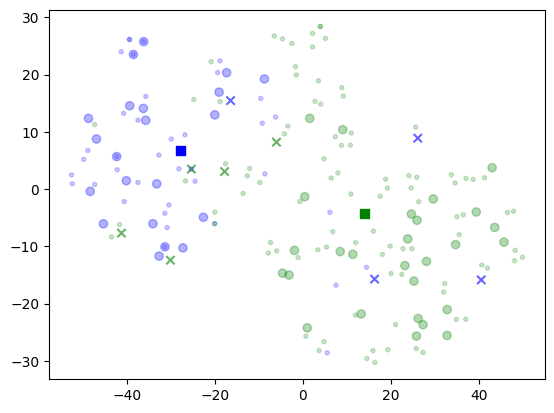

In [89]:
tsne = TSNE(n_components=2, metric="cosine", random_state=RANDOM_SEED, perplexity=15)
vis_dims = tsne.fit_transform(mat.cpu())
colors = ["blue", "green"]
X = np.array([x for x, _ in vis_dims])
xtrain = X[model.weight.size(0) : len(train_ld) + model.weight.size(0)]
xtest = X[len(train_ld) + model.weight.size(0) :]
Y = np.array([y for _, y in vis_dims])
ytrain = Y[model.weight.size(0) : len(train_ld) + model.weight.size(0)]
ytest = Y[len(train_ld) + model.weight.size(0) :]

color_indices = true_labels
ci_train = color_indices[: len(train_ld)]
ci_test = color_indices[len(train_ld) :]


colormap = matplotlib.colors.ListedColormap(colors)

mask = np.ones(len(test_ld), dtype=bool)
mask[incorrect] = False

plt.scatter(xtest[mask], ytest[mask], c=ci_test[mask], cmap=colormap, alpha=0.3)

plt.scatter(xtest[incorrect], ytest[incorrect], c=ci_test[incorrect], cmap=colormap, alpha=0.6, marker="x")

plt.scatter(xtrain, ytrain, c=ci_train, cmap=colormap, alpha=0.2, marker=".")

plt.scatter(X[: model.weight.size(0)], Y[: model.weight.size(0)], c=[0, 1], cmap=colormap, marker="s")

plt.show(block=True)

In [37]:
tsne = TSNE(n_components=2, metric="cosine", random_state=42, perplexity=15)
vis_dims = tsne.fit_transform(mat.cpu())
colors = ["blue", "green"]
X = np.array([x for x, _ in vis_dims])
x = X[model.weight.size(0) :]
Y = np.array([y for _, y in vis_dims])
y = Y[model.weight.size(0) :]
color_indices = true_labels


colormap = matplotlib.colors.ListedColormap(colors)

mask = np.ones(len(test_ld), dtype=bool)
mask[incorrect] = False

plt.scatter(x[mask], y[mask], c=color_indices[mask], cmap=colormap, alpha=0.3)

plt.scatter(x[incorrect], y[incorrect], c=color_indices[incorrect], cmap=colormap, alpha=0.6, marker="x")

plt.scatter(X[: model.weight.size(0)], Y[: model.weight.size(0)], c=[0, 1], cmap=colormap, marker="s")

plt.show(block=True)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1113 but corresponding boolean dimension is 334

ValueError: DataFrame constructor not properly called!